In [9]:
import torch
#torch.multiprocessing.set_start_method('spawn')
import pandas as pd
import unicodedata
import os
from sklearn.metrics import f1_score
import numpy as np
from scipy import stats

In [10]:
#dev_df = pd.read_csv('../data/dev_data.csv', encoding="utf8")
test_df = pd.read_csv('../data/test_data_with_label.csv', encoding="utf8")

In [11]:
import unicodedata
def reencode_and_normalize(text):
    transl_table = dict([(ord(x), ord(y)) for x,y in zip( u"‘’´“”–-",  u"'''\"\"--")])
    fixed_text = text.replace('鈥�', '"').replace('鉂�', '').encode('gb18030').decode('utf8')
    fixed_text = unicodedata.normalize("NFKD", fixed_text)
    fixed_text = fixed_text.translate(transl_table)
    return fixed_text

test_df['Text data'] = test_df['Text data'].apply(reencode_and_normalize)

In [12]:
test_df['Text data'] = test_df['Text data'].str.strip()
#dev_df['text data'] = dev_df['text data'].str.strip()

In [13]:
test_texts = list(test_df['Text data'].values)
#dev_texts = list(dev_df['text data'].values)

In [18]:
models_path = 'kfold/output'
n_folds = 4

model_names = [d for d in os.listdir(models_path) if os.path.isdir(os.path.join(models_path, d)) and not d.startswith('.')]

In [19]:
model_names

['regression-v2',
 'deberta-mental-health-v3',
 'oll-roberta-mental-health-v2-fixloss',
 'roberta-large-v3-maxlen',
 'deberta-large-v3-maxlen',
 'roberta-mental-health-headtail-75',
 'roberta-large-v3-maxlen_class_weights',
 'roberta-mental-health-headtail-0',
 'roberta-large-v3-maxlen_oversampled',
 'roberta-mental-health-v3-maxlen',
 'corn-roberta-mental-health-v2',
 'roberta-mental-health-headtail-50',
 'roberta-mental-health-headtail-25',
 'roberta-mental-health-v6-labelsmoothing']

In [20]:
id2label = {
    0:"not depression",
    1:"moderate",
    2:"severe"
}

label2id = {v: k for k, v in id2label.items()}

In [9]:
from transformers import AutoModelForSequenceClassification, AutoTokenizer
from hypsearch.coral import CoralRobertaForSequenceClassification
import torch
import os
import json

def load_model(model_path):
    with open(os.path.join(model_path, 'config.json'), 'r') as f:
        config = json.load(f)
    if 'class_regression' in config and config['class_regression']:
        model = AutoModelForSequenceClassification.from_pretrained(model_path, num_labels=1)
    elif ('corn_model' in config or 'coral_model' in config) and (config['corn_model'] or config['coral_model']):
        model = CoralRobertaForSequenceClassification.from_pretrained(model_path)
    else:
        model = AutoModelForSequenceClassification.from_pretrained(model_path)
    tokenizer = AutoTokenizer.from_pretrained(model_path)
    return model, tokenizer

#model, tokenizer = load_model('hypsearch/output/roberta-large-v3-maxlen/trial_4')
#model = model.to(device)

In [10]:
import torch.nn.functional as F
from hypsearch.coral import proba_to_label_np, corn_label_from_logits_np
import numpy as np
import gc

def predict(texts, model, tokenizer, batchsize=64, device=torch.device('cpu'), max_seq_length=512):
    all_logits = []
    for i in range(0, len(texts), batchsize):
        #print(len(all_logits), len(texts)//batchsize)
        batch = texts[i:i+batchsize]
        
        max_head_limit = None
        if hasattr(model.config, 'max_head_limit'):
            max_head_limit = model.config.max_head_limit
            
        if max_head_limit is None:
            inputs = tokenizer(batch, truncation=True, padding=True, return_tensors='pt', max_length=max_seq_length).to(device)
        else:
            head_limit = max_head_limit
            if isinstance(head_limit, float):
                head_limit = round(max_seq_length*head_limit)
                if head_limit == 0:
                    head_limit = 1
            #print('head_limit', head_limit)
            inputs = {
                'input_ids': [],
                'attention_mask': []
            }
            tokenized_dataset = tokenizer(batch, padding=True, truncation=False)
            token_to_find = tokenizer.sep_token_id
            for tokens, attention_mask in zip(tokenized_dataset['input_ids'], tokenized_dataset['attention_mask']):
                size = tokens.index(token_to_find) + 1
                if size > max_seq_length:
                    inputs['input_ids'].append(tokens[:head_limit]+ tokens[size-max_seq_length+head_limit:size])
                    inputs['attention_mask'].append(attention_mask[:head_limit]+ attention_mask[size-max_seq_length+head_limit:size])
                else:
                    inputs['input_ids'].append(tokens[:max_seq_length])
                    inputs['attention_mask'].append(attention_mask[:max_seq_length])
            inputs['input_ids'] = torch.tensor(inputs['input_ids'], dtype=torch.long, device=device)
            inputs['attention_mask'] = torch.tensor(inputs['attention_mask'], dtype=torch.long, device=device)

        with torch.no_grad():
            outputs = model(**inputs)

        all_logits.append(outputs.logits.detach().cpu())
        
        del inputs
        del outputs
    
    all_logits = torch.cat(all_logits)
    softmax = F.softmax(all_logits, dim=-1).numpy()
    all_logits = all_logits.numpy()
    
    if (hasattr(model.config, 'class_regression') and model.config.class_regression) or (hasattr(model.config, 'problem_type') and model.config.problem_type == "regression"):
        soft_preds = np.squeeze(all_logits)
        preds = np.clip(np.round(soft_preds).astype(int), 0, len(label2id)-1) 
        logits_output = np.eye(len(label2id))[preds]
        softmax_output = logits_output.copy()
    elif (hasattr(model.config, 'corn_model') and model.config.corn_model):
        preds = corn_label_from_logits_np(all_logits)
        soft_preds = preds.copy()
        logits_output = np.eye(len(label2id))[preds]
        softmax_output = logits_output.copy()
    elif (hasattr(model.config, 'coral_model') and model.config.coral_model):
        return None
    else:
        remap_labels = []
        for label in label2id:
            remap_labels.append(model.config.label2id[label])
        logits_output = all_logits[:, remap_labels].copy()
        softmax_output = softmax[:, remap_labels].copy()
        preds = softmax_output.argmax(-1)
        
        #soft preds
        #[0.7, 0.1, 0.2] -> (0 + 0.1 + 0.2) -> 0.3
        #[0.1, 0.7, 0.2] -> (1 - 0.1 + 0.2) -> 1.1
        #[0.1, 0.2, 0.7] -> (2 - 0.1 - 0.2) -> 1.7
        
        #[0.3, 0.3, 0.4] -> (2 - 0.3 - 0.3) -> 1.4 .round() -> 1 #error
        #[0.3333, 0.333, 0.33..4] -> lower bound
        #[0.49, 0.0, 0.51] -> (2 - 0.49 - 0.0) -> 1.51 .round() -> 2
        dist_mask = np.array([
            [0, 1, 1],
            [-1, 0, 1],
            [-1, -1, 0]
        ])

        soft_preds = preds + np.clip(np.sum(dist_mask[preds] * softmax_output, axis=-1), -0.499, 0.499)
    
    gc.collect()
    torch.cuda.empty_cache()
    
    return preds, soft_preds, softmax_output, logits_output

In [11]:
dev_outputs = {model_name: {} for model_name in model_names}
test_outputs = {model_name: {} for model_name in model_names}

In [14]:
#del dev_outputs['.ipynb_checkpoints']
#del test_outputs['.ipynb_checkpoints']

In [21]:
import pickle
if os.path.exists('dev_outputs.pickle'):
    with open('dev_outputs.pickle', 'rb') as f:
        dev_outputs = pickle.load(f)
    with open('test_outputs.pickle', 'rb') as f:
        test_outputs = pickle.load(f)

In [21]:
"""
device = torch.device('cuda:7')
for fold in range(n_folds):
    dev_df = pd.read_csv(f'./kfold/{fold}/dev_data.csv', encoding="utf8")
    dev_df['text data'] = dev_df['text data'].str.strip()
    dev_texts = list(dev_df['text data'].values)
    for model_name in model_names:
        if len(dev_outputs[model_name][fold]) > 0 and len(test_outputs[model_name][fold]) > 0:
            print(f"skipping {model_name}/fold_{fold}")
            continue
        
        model_path = os.path.join(models_path, model_name, 'fold_'+str(fold))
        print(model_path)
        
        model, tokenizer = load_model(model_path)
        model = model.to(device)
        
        model_outputs = predict(dev_texts, model, tokenizer, batchsize=128, device=device)
        dev_outputs[model_name][fold].append(model_outputs)
        
        model_outputs = predict(test_texts, model, tokenizer, batchsize=128, device=device)
        test_outputs[model_name][fold].append(model_outputs)
        
        del model
        gc.collect()
        torch.cuda.empty_cache()
"""

skipping regression-v2_0
skipping deberta-mental-health-v3_0
skipping oll-roberta-mental-health-v2-fixloss_0
skipping roberta-large-v3-maxlen_0
skipping deberta-large-v3-maxlen_0
skipping roberta-mental-health-headtail-75_0
skipping roberta-mental-health-headtail-0_0
skipping roberta-mental-health-v3-maxlen_0
skipping corn-roberta-mental-health-v2_0
skipping roberta-mental-health-headtail-50_0
skipping roberta-mental-health-headtail-25_0
skipping roberta-mental-health-v6-labelsmoothing_0
kfold/output/regression-v2/fold_1


Token indices sequence length is longer than the specified maximum sequence length for this model (1082 > 512). Running this sequence through the model will result in indexing errors


kfold/output/deberta-mental-health-v3/fold_1
kfold/output/oll-roberta-mental-health-v2-fixloss/fold_1


Token indices sequence length is longer than the specified maximum sequence length for this model (1082 > 512). Running this sequence through the model will result in indexing errors


kfold/output/roberta-large-v3-maxlen/fold_1
kfold/output/deberta-large-v3-maxlen/fold_1


KeyboardInterrupt: 

In [12]:
from multiprocessing import Pool, current_process, Queue

NUM_GPUS = 4
PROC_PER_GPU = 1    

queue = Queue()

data = []
for fold in range(n_folds):
    for model_name in model_names:
        data.append((fold, model_name))
        
def foo(model_data):
    device = queue.get()
    #torch.multiprocessing.set_start_method('spawn')
    #device = torch.device(f'cuda:{gpu_id}')
    fold, model_name = model_data
    try:
        # run processing on GPU <gpu_id>
        ident = current_process().ident
        print('{}: starting process on GPU {}'.format(ident, device))
        
        if len(dev_outputs[model_name][fold]) > 0 and len(test_outputs[model_name][fold]) > 0:
            print(f"skipping {model_name}/fold_{fold}")
            return fold, model_name, dev_outputs[model_name][fold], test_outputs[model_name][fold]
        
        dev_df = pd.read_csv(f'./kfold/{fold}/dev_data.csv', encoding="utf8")
        dev_df['text data'] = dev_df['text data'].str.strip()
        dev_texts = list(dev_df['text data'].values)
        
        model_path = os.path.join(models_path, model_name, 'fold_'+str(fold))
        print(model_path)
        
        model, tokenizer = load_model(model_path)
        model = model.to(device)
        
        dev_model_outputs = predict(dev_texts, model, tokenizer, batchsize=128, device=device)
        #dev_outputs[model_name][fold].append(model_outputs)
        
        test_model_outputs = predict(test_texts, model, tokenizer, batchsize=128, device=device)
        #test_outputs[model_name][fold].append(model_outputs)
        
        del model
        gc.collect()
        torch.cuda.empty_cache()
        
        print('{}: finished'.format(ident))
        return fold, model_name, dev_model_outputs, test_model_outputs
    finally:
        queue.put(device)

# initialize the queue with the GPU ids
for gpu_id in [1,5,6,7]:
    for _ in range(PROC_PER_GPU):
        queue.put(torch.device(f'cuda:{gpu_id}'))

pool = Pool(processes=PROC_PER_GPU * NUM_GPUS)
for results in pool.imap_unordered(foo, data):
    fold, model_name, dev_model_outputs, test_model_outputs = results
    dev_outputs[model_name][fold] = dev_model_outputs
    test_outputs[model_name][fold] = test_model_outputs
pool.close()
pool.join()

36520: starting process on GPU cuda:1
36521: starting process on GPU cuda:5
36522: starting process on GPU cuda:6
36523: starting process on GPU cuda:7
kfold/output/regression-v2/fold_0
kfold/output/deberta-mental-health-v3/fold_0
kfold/output/oll-roberta-mental-health-v2-fixloss/fold_0
kfold/output/roberta-large-v3-maxlen/fold_0


/opt/conda/lib/python3.8/site-packages/torch/nn/modules/module.py:1383: UserWarning: positional arguments and argument "destination" are deprecated. nn.Module.state_dict will not accept them in the future. Refer to https://pytorch.org/docs/master/generated/torch.nn.Module.html#torch.nn.Module.state_dict for details.
  warnings.warn(
/opt/conda/lib/python3.8/site-packages/torch/nn/modules/module.py:1383: UserWarning: positional arguments and argument "destination" are deprecated. nn.Module.state_dict will not accept them in the future. Refer to https://pytorch.org/docs/master/generated/torch.nn.Module.html#torch.nn.Module.state_dict for details.
  warnings.warn(
/opt/conda/lib/python3.8/site-packages/torch/nn/modules/module.py:1383: UserWarning: positional arguments and argument "destination" are deprecated. nn.Module.state_dict will not accept them in the future. Refer to https://pytorch.org/docs/master/generated/torch.nn.Module.html#torch.nn.Module.state_dict for details.
  warnings.w

36523: finished
36523: starting process on GPU cuda:7
kfold/output/deberta-large-v3-maxlen/fold_0
36520: finished
36520: starting process on GPU cuda:1
kfold/output/roberta-mental-health-headtail-75/fold_0
36522: finished
36522: starting process on GPU cuda:6
kfold/output/roberta-mental-health-headtail-0/fold_0


Token indices sequence length is longer than the specified maximum sequence length for this model (1174 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (1174 > 512). Running this sequence through the model will result in indexing errors


36521: finished
36521: starting process on GPU cuda:5
kfold/output/roberta-mental-health-v3-maxlen/fold_0
36520: finished
36520: starting process on GPU cuda:1
kfold/output/corn-roberta-mental-health-v2/fold_0
36522: finished
36522: starting process on GPU cuda:6
kfold/output/roberta-mental-health-headtail-50/fold_0


Token indices sequence length is longer than the specified maximum sequence length for this model (1174 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (1174 > 512). Running this sequence through the model will result in indexing errors


36521: finished
36521: starting process on GPU cuda:5
kfold/output/roberta-mental-health-headtail-25/fold_0
36523: finished
36523: starting process on GPU cuda:7
kfold/output/roberta-mental-health-v6-labelsmoothing/fold_0


Token indices sequence length is longer than the specified maximum sequence length for this model (1174 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (1174 > 512). Running this sequence through the model will result in indexing errors


36520: finished
36520: starting process on GPU cuda:1
kfold/output/regression-v2/fold_1


Token indices sequence length is longer than the specified maximum sequence length for this model (1082 > 512). Running this sequence through the model will result in indexing errors


36522: finished
36522: starting process on GPU cuda:6
kfold/output/deberta-mental-health-v3/fold_1
36521: finished
36521: starting process on GPU cuda:5
kfold/output/oll-roberta-mental-health-v2-fixloss/fold_1
36523: finished
36523: starting process on GPU cuda:7
kfold/output/roberta-large-v3-maxlen/fold_1


Token indices sequence length is longer than the specified maximum sequence length for this model (1082 > 512). Running this sequence through the model will result in indexing errors


36520: finished
36520: starting process on GPU cuda:1
kfold/output/deberta-large-v3-maxlen/fold_1
36521: finished
36521: starting process on GPU cuda:5
kfold/output/roberta-mental-health-headtail-75/fold_1
36523: finished
36523: starting process on GPU cuda:7
kfold/output/roberta-mental-health-headtail-0/fold_1


Token indices sequence length is longer than the specified maximum sequence length for this model (1082 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (1082 > 512). Running this sequence through the model will result in indexing errors


36522: finished
36522: starting process on GPU cuda:6
kfold/output/roberta-mental-health-v3-maxlen/fold_1
36521: finished
36521: starting process on GPU cuda:5
kfold/output/corn-roberta-mental-health-v2/fold_1
36520: finished
36520: starting process on GPU cuda:1
kfold/output/roberta-mental-health-headtail-50/fold_1
36523: finished
36523: starting process on GPU cuda:7
kfold/output/roberta-mental-health-headtail-25/fold_1


Token indices sequence length is longer than the specified maximum sequence length for this model (1082 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (1082 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (1082 > 512). Running this sequence through the model will result in indexing errors


36522: finished
36522: starting process on GPU cuda:6
kfold/output/roberta-mental-health-v6-labelsmoothing/fold_1


Token indices sequence length is longer than the specified maximum sequence length for this model (1082 > 512). Running this sequence through the model will result in indexing errors


36520: finished
36520: starting process on GPU cuda:1
kfold/output/regression-v2/fold_2
36521: finished
36521: starting process on GPU cuda:5
kfold/output/deberta-mental-health-v3/fold_2
36523: finished
36523: starting process on GPU cuda:7
kfold/output/oll-roberta-mental-health-v2-fixloss/fold_2


Token indices sequence length is longer than the specified maximum sequence length for this model (2203 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (2203 > 512). Running this sequence through the model will result in indexing errors


36522: finished
36522: starting process on GPU cuda:6
kfold/output/roberta-large-v3-maxlen/fold_2
36520: finished
36520: starting process on GPU cuda:1
kfold/output/deberta-large-v3-maxlen/fold_2
36523: finished
36523: starting process on GPU cuda:7
kfold/output/roberta-mental-health-headtail-75/fold_2


Token indices sequence length is longer than the specified maximum sequence length for this model (2203 > 512). Running this sequence through the model will result in indexing errors


36522: finished
36522: starting process on GPU cuda:6
kfold/output/roberta-mental-health-headtail-0/fold_2


Token indices sequence length is longer than the specified maximum sequence length for this model (2203 > 512). Running this sequence through the model will result in indexing errors


36521: finished
36521: starting process on GPU cuda:5
kfold/output/roberta-mental-health-v3-maxlen/fold_2
36523: finished
36523: starting process on GPU cuda:7
kfold/output/corn-roberta-mental-health-v2/fold_2


Token indices sequence length is longer than the specified maximum sequence length for this model (2203 > 512). Running this sequence through the model will result in indexing errors


36522: finished
36522: starting process on GPU cuda:6
kfold/output/roberta-mental-health-headtail-50/fold_2


Token indices sequence length is longer than the specified maximum sequence length for this model (2203 > 512). Running this sequence through the model will result in indexing errors


36520: finished
36520: starting process on GPU cuda:1
kfold/output/roberta-mental-health-headtail-25/fold_2
36521: finished
36521: starting process on GPU cuda:5
kfold/output/roberta-mental-health-v6-labelsmoothing/fold_2


Token indices sequence length is longer than the specified maximum sequence length for this model (2203 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (2203 > 512). Running this sequence through the model will result in indexing errors


36523: finished
36523: starting process on GPU cuda:7
kfold/output/regression-v2/fold_3


Token indices sequence length is longer than the specified maximum sequence length for this model (1512 > 512). Running this sequence through the model will result in indexing errors


36522: finished
36522: starting process on GPU cuda:6
kfold/output/deberta-mental-health-v3/fold_3
36520: finished
36520: starting process on GPU cuda:1
kfold/output/oll-roberta-mental-health-v2-fixloss/fold_3


Token indices sequence length is longer than the specified maximum sequence length for this model (1512 > 512). Running this sequence through the model will result in indexing errors


36521: finished
36521: starting process on GPU cuda:5
kfold/output/roberta-large-v3-maxlen/fold_3
36523: finished
36523: starting process on GPU cuda:7
kfold/output/deberta-large-v3-maxlen/fold_3
36520: finished
36520: starting process on GPU cuda:1
kfold/output/roberta-mental-health-headtail-75/fold_3


Token indices sequence length is longer than the specified maximum sequence length for this model (1512 > 512). Running this sequence through the model will result in indexing errors


36521: finished
36521: starting process on GPU cuda:5
kfold/output/roberta-mental-health-headtail-0/fold_3


Token indices sequence length is longer than the specified maximum sequence length for this model (1512 > 512). Running this sequence through the model will result in indexing errors


36522: finished
36522: starting process on GPU cuda:6
kfold/output/roberta-mental-health-v3-maxlen/fold_3
36520: finished
36520: starting process on GPU cuda:1
kfold/output/corn-roberta-mental-health-v2/fold_3


Token indices sequence length is longer than the specified maximum sequence length for this model (1512 > 512). Running this sequence through the model will result in indexing errors


36523: finished
36523: starting process on GPU cuda:7
kfold/output/roberta-mental-health-headtail-50/fold_3


Token indices sequence length is longer than the specified maximum sequence length for this model (1512 > 512). Running this sequence through the model will result in indexing errors


36521: finished
36521: starting process on GPU cuda:5
kfold/output/roberta-mental-health-headtail-25/fold_3


Token indices sequence length is longer than the specified maximum sequence length for this model (1512 > 512). Running this sequence through the model will result in indexing errors


36522: finished
36522: starting process on GPU cuda:6
kfold/output/roberta-mental-health-v6-labelsmoothing/fold_3


Token indices sequence length is longer than the specified maximum sequence length for this model (1512 > 512). Running this sequence through the model will result in indexing errors


36520: finished
36523: finished
36521: finished
36522: finished


In [13]:
gc.collect()
torch.cuda.empty_cache()

In [14]:
"""
import pickle
with open('dev_outputs.pickle', 'wb') as f:
    pickle.dump(dev_outputs, f)
with open('test_outputs.pickle', 'wb') as f:
    pickle.dump(test_outputs, f)
"""

In [26]:
import json
model_scores = []
temp_model_names = model_names.copy()
model_names = []
for model_name in temp_model_names:
    results_path = os.path.join(models_path, model_name, 'mean_run_results.json')
    if not os.path.exists(results_path) or 'class_weights' in model_name:
        continue
    model_names.append(model_name)
    with open(results_path, 'r') as f:
        results = json.load(f)
    model_scores.append(results["eval_f1 (macro)"])
    #model_scores[model_name] = results["eval_f1 (macro)"]
model_scores = np.asarray(model_scores)

In [27]:
dev_y_true = []
for fold in range(n_folds):
    dev_df = pd.read_csv(f'./kfold/{fold}/dev_data.csv', encoding="utf8")
    y_true = dev_df['label'].map(label2id).values
    dev_y_true.append(y_true)

In [33]:
score_sort = np.flip(model_scores.argsort())
sorted_model_names = np.asarray(model_names)[score_sort]
all_scores = []
for i in range(len(score_sort)):
    i = i+1
    print(i)
    for fold in range(n_folds):
        y_true = dev_y_true[fold]
        
        selected_model_names = sorted_model_names[:i]
        
        preds = np.asarray([dev_outputs[model_name][fold][0] for model_name in selected_model_names])
        soft_preds = np.asarray([dev_outputs[model_name][fold][1] for model_name in selected_model_names])
        softmax = np.asarray([dev_outputs[model_name][fold][2] for model_name in selected_model_names])
        logits = np.asarray([dev_outputs[model_name][fold][3] for model_name in selected_model_names])
        
        temp_results = {
            "softmax_mean_preds": np.mean(softmax, axis=0).argmax(-1),
            #"softmax_max_preds": np.max(softmax, axis=0).argmax(-1),
            #"logits_mean_preds": np.mean(logits, axis=0).argmax(-1),
            #"logits_max_preds": np.max(logits, axis=0).argmax(-1),
            "preds_mode": stats.mode(preds, axis=0).mode[0],
            "preds_ordered_mean": np.mean(preds, axis=0).round(),
            #"softmax_to_scalar_mean": np.mean(soft_preds, axis=0).round()
        }
        i_scores = {'i': i, 'fold': fold}
        for r in temp_results:
            i_scores[r] = f1_score(y_true, temp_results[r], average="macro")

        all_scores.append(i_scores)

1
2
3
4
5
6
7
8
9
10
11
12


In [34]:
import pandas as pd
df_scores = pd.DataFrame(all_scores)
df_scores.max().sort_values(ascending=False)

i                     12.000000
fold                   3.000000
softmax_mean_preds     0.649661
preds_mode             0.643666
preds_ordered_mean     0.643123
dtype: float64

In [35]:
df_scores.groupby('i').mean()

,fold,softmax_mean_preds,preds_mode,preds_ordered_mean
i,,,,
1,1.5,0.617868,0.617868,0.617868
2,1.5,0.619412,0.617320,0.615497
3,1.5,0.625724,0.625616,0.622821
4,1.5,0.626420,0.622458,0.622906
5,1.5,0.623963,0.623825,0.622210
6,1.5,0.624981,0.625049,0.622107
7,1.5,0.628342,0.628872,0.625932
8,1.5,0.627416,0.628599,0.627949
9,1.5,0.627623,0.630987,0.628563


<AxesSubplot:xlabel='Number of Models'>

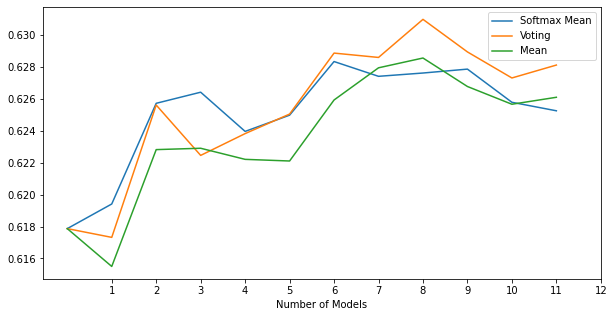

In [85]:
df_scores.groupby('i').mean().reset_index(drop=True) \
    .drop('fold', axis=1) \
    .rename(columns={'softmax_mean_preds': 'Softmax Mean',
             'preds_ordered_mean': 'Mean', 
             'preds_mode': 'Voting'})\
    .rename_axis('Number of Models').plot(figsize=(10, 5), xticks=df_scores['i'].unique())

In [31]:
df_scores.groupby('i').mean().mean().sort_values(ascending=False)

fold                      1.500000
preds_mode                0.625415
softmax_mean_preds        0.625055
logits_mean_preds         0.624508
preds_ordered_mean        0.623700
softmax_to_scalar_mean    0.621929
logits_max_preds          0.618392
softmax_max_preds         0.615026
dtype: float64

In [32]:
df_scores.groupby('i').mean().max().sort_values(ascending=False)

fold                      1.500000
preds_mode                0.630987
preds_ordered_mean        0.628563
softmax_mean_preds        0.628342
logits_mean_preds         0.627189
softmax_max_preds         0.624583
softmax_to_scalar_mean    0.623753
logits_max_preds          0.621622
dtype: float64

In [50]:
analysis_model_score = []
for i, model_name in enumerate(sorted_model_names):
    for fold in range(n_folds):
        with open(os.path.join(models_path, model_name, f"fold_{fold}", 'all_results.json'), 'r') as f:
            results = json.load(f)
        analysis_model_score.append({'order': i, 'model_name': model_name, 'fold': fold, 'f1_macro': results["eval_f1 (macro)"]})
df_analysis = pd.DataFrame(analysis_model_score)

In [51]:
min_dict = df_analysis.groupby("fold")["f1_macro"].min().to_dict()
max_dict = df_analysis.groupby("fold")["f1_macro"].max().to_dict()
df_analysis['f1_macro_norm'] = df_analysis.apply(lambda row: (row['f1_macro'] - min_dict[row['fold']])/(max_dict[row['fold']] - min_dict[row['fold']]), axis=1)

In [52]:
df_analysis.sort_values(["f1_macro_norm"], ascending=False)

,order,model_name,fold,f1_macro,f1_macro_norm
0,0,roberta-mental-health-headtail-50,0,0.627637,1.000000
15,3,roberta-large-v3-maxlen,3,0.622300,1.000000
30,7,deberta-mental-health-v3,2,0.608772,1.000000
5,1,roberta-mental-health-headtail-25,1,0.635307,1.000000
18,4,roberta-mental-health-headtail-75,2,0.607931,0.965447
2,0,roberta-mental-health-headtail-50,2,0.606738,0.916430
17,4,roberta-mental-health-headtail-75,1,0.633013,0.915506
22,5,roberta-mental-health-v6-labelsmoothing,2,0.606556,0.908957
24,6,corn-roberta-mental-health-v2,0,0.624580,0.871162
4,1,roberta-mental-health-headtail-25,0,0.624477,0.866824


In [53]:
import plotly
import plotly.express as px

fig = px.scatter(df_analysis, x="fold", y="f1_macro_norm", color="model_name")
plotly.io.write_image(fig, 'output_file.pdf', format='pdf')

In [127]:
i = 9
mean_preds = []
mode_preds = []
all_preds = []
mean_softmaxs = []
mean_logits = []
selected_model_names = sorted_model_names[:i]
for model_name in selected_model_names:
    fold_preds = np.asarray([test_outputs[model_name][fold][0] for fold in range(n_folds)])
    fold_softmaxs = np.asarray([test_outputs[model_name][fold][2] for fold in range(n_folds)])
    fold_logits = np.asarray([test_outputs[model_name][fold][3] for fold in range(n_folds)])
    all_preds.extend(fold_preds)
    model_mod_preds = stats.mode(fold_preds, axis=0).mode[0]
    mode_preds.append(model_mod_preds)
    model_mean_preds = np.mean(fold_preds, axis=0).round()
    mean_preds.append(model_mean_preds)
    mean_softmax = np.mean(fold_softmaxs, axis=0)
    mean_softmaxs.append(mean_softmax)
    mean_logit = np.mean(fold_logits, axis=0)
    mean_logits.append(mean_logit)
preds = np.asarray(preds)

In [128]:
results = {
    "best_model_mode": mode_preds[0],
    "best_model_mean": mean_preds[0],
    "best_model_softmax": mean_softmaxs[0].argmax(axis=1),
    "best_model_logits": mean_logits[0].argmax(axis=1),
    "best_model_fold1_preds": test_outputs[selected_model_names[0]][3][0],
    "s1_model_mode": mode_preds[3],
    "s1_model_mean": mean_preds[3],
    "s1_model_softmax": mean_softmaxs[3].argmax(axis=1),
    #"mode_mode": stats.mode(mode_preds, axis=0).mode[0],
    "mode_mean": stats.mode(mean_preds, axis=0).mode[0],
    "mode_all": stats.mode(all_preds, axis=0).mode[0],
    "softmax_all": np.mean(mean_softmaxs, axis=0).argmax(axis=1),
    #"mean_mode": np.mean(mode_preds, axis=0).round(),
    #"mean_mean": np.mean(mean_preds, axis=0).round(),
    #"mean_all": np.mean(all_preds, axis=0).round(),
}

In [129]:
i_scores = {}
test_y_true = test_df['Label'].map(label2id).values
for r in results:
    i_scores[r] = f1_score(test_y_true, results[r], average="macro")
i_scores

{'best_model_mode': 0.4634765971078402,
 'best_model_mean': 0.4678242848916388,
 'best_model_softmax': 0.49153318277165753,
 'best_model_logits': 0.48775718862675377,
 'best_model_fold1_preds': 0.4765829224325954,
 's1_model_mode': 0.4479995191360986,
 's1_model_mean': 0.44971944372792727,
 's1_model_softmax': 0.45046604302135335,
 'mode_mean': 0.4435152053234326,
 'mode_all': 0.4512634212924254,
 'softmax_all': 0.4667614051510344}

In [56]:
pairs = set()
for k1 in results.keys():
    for k2 in results.keys():
        if k1 == k2:
            continue
        key_pair = frozenset([k1, k2])
        pairs.add(key_pair)

In [58]:
for pair in pairs:
    pair = list(pair)
    print(pair[0], pair[1], (results[pair[0]] != results[pair[1]]).sum())

best_model_mean mode_all 39
mode_all mode_mean 30
best_model_mean mode_mean 31


In [139]:
results = {
    #"BestModel": mode_preds[0],
    "BestModel4Mean": mean_preds[0],
    #"KFoldMode": stats.mode(mode_preds, axis=0).mode[0],
    "KFoldMean9Mode": stats.mode(mean_preds, axis=0).mode[0],
    "All36Mode": stats.mode(all_preds, axis=0).mode[0],
    #"mean_mode": np.mean(mode_preds, axis=0).round(),
    #"mean_mean": np.mean(mean_preds, axis=0).round(),
    #"mean_all": np.mean(all_preds, axis=0).round(),
}

for name, preds_model in results.items():
    sub_df = test_df.copy()
    sub_df['class_label'] = preds_model
    sub_df['class_label'] = sub_df['class_label'].map(id2label)
    sub_df['pid'] = sub_df['Pid']
    sub_df.to_csv(os.path.join('submissions', name+'_v2.csv'), index=False)
    sub_df[['pid', 'class_label']].to_csv(os.path.join('submissions', 'DeepLearningBrasil_'+name+'_v2.tsv'), sep='\t', index=False)

In [69]:
(results["best_model"] != results["mode"]).sum()

29

In [68]:
(results["best_model"] != results["mode_all"]).sum()

34

In [67]:
(results["mode_all"] != results["mode"]).sum()

27

In [15]:
def ordered_mean(preds):
    #map_ordered = {0:1, 1:0, 2:2}
    #unmap_ordered = {1:0, 0:1, 2:2}
    
    pred_ordered = preds#np.vectorize(lambda x: map_ordered[x])(preds)
    pred_ordered_mean = np.mean(pred_ordered, axis=0).round()
    #pred_ordered_mean_unmap = np.vectorize(lambda x: unmap_ordered[x])(pred_ordered_mean)
    return pred_ordered

def softmax_to_scalar_mean(softmax):
    #[0.7, 0.1, 0.2] -> (0 + 0.1 + 0.2) -> 0.3
    #[0.1, 0.7, 0.2] -> (1 - 0.1 + 0.2) -> 1.1
    #[0.1, 0.2, 0.7] -> (2 - 0.1 - 0.2) -> 1.7
    
    #[0.49, 0.0, 0.51] -> (2 - 0.49 - 0.0) -> 1.51 .round() -> 2
    #map_ordered = [1,0,2]
    #unmap_ordered = {1:0, 0:1, 2:2}
    dist_mask = np.array([
        [0, 1, 1],
        [-1, 0, 1],
        [-1, -1, 0]
    ])
    
    #map_ordered = [1,0,2]
    softmax_ordered = softmax#[:, :, map_ordered]
    preds_ordered = softmax_ordered.argmax(-1)
    scalar_labels = preds_ordered + np.sum(dist_mask[preds_ordered] * softmax_ordered, axis=-1)
    scalar_labels_mean = np.mean(scalar_labels, axis=0).round()
    #scalar_labels_mean_unmap = np.vectorize(lambda x: unmap_ordered[x])(scalar_labels_mean)
    return scalar_labels_mean#_unmap

In [16]:
score_sort = np.flip(model_scores.argsort())
all_scores = []
for i in range(len(score_sort)):
    i = i+1
    print(i)
    temp_results = {
        "softmax_mean_preds": np.mean(softmax[score_sort][:i], axis=0).argmax(-1),
        "softmax_max_preds": np.max(softmax[score_sort][:i], axis=0).argmax(-1),
        "logits_mean_preds": np.mean(logits[score_sort][:i], axis=0).argmax(-1),
        "logits_max_preds": np.max(logits[score_sort][:i], axis=0).argmax(-1),
        "preds_mode": stats.mode(preds[score_sort][:i], axis=0).mode[0],
        "preds_ordered_mean": np.mean(preds[score_sort][:i], axis=0).round(),
        "softmax_to_scalar_mean": np.mean(soft_preds[score_sort][:i], axis=0).round()
    }
    i_scores = {'i': i}
    for r in temp_results:
        i_scores[r] = f1_score(y_true, temp_results[r], average="macro")
    
    all_scores.append(i_scores)

1
2
3
4
5
6
7
8
9
10
11
12


In [17]:
(preds[score_sort[0]] != soft_preds[score_sort[0]].round()).sum()

0

In [18]:
preds[score_sort[0]][(preds[score_sort[0]] != soft_preds[score_sort[0]].round())]

array([], dtype=int64)

In [19]:
soft_preds[score_sort[0]][(preds[score_sort[0]] != soft_preds[score_sort[0]].round())]

array([], dtype=float64)

In [20]:
import pandas as pd
df_scores = pd.DataFrame(all_scores)
df_scores.max().sort_values(ascending=False)

i                         12.000000
preds_ordered_mean         0.616459
preds_mode                 0.613477
softmax_to_scalar_mean     0.605563
softmax_mean_preds         0.604406
logits_mean_preds          0.602459
logits_max_preds           0.595776
softmax_max_preds          0.593982
dtype: float64

In [24]:
df_scores.mean().sort_values(ascending=False)

i                         6.500000
preds_ordered_mean        0.605867
preds_mode                0.603373
softmax_to_scalar_mean    0.601801
softmax_mean_preds        0.598653
logits_mean_preds         0.597429
softmax_max_preds         0.589351
logits_max_preds          0.584376
dtype: float64

In [21]:
df_scores

,i,softmax_mean_preds,softmax_max_preds,logits_mean_preds,logits_max_preds,preds_mode,preds_ordered_mean,softmax_to_scalar_mean
0,1,0.593982,0.593982,0.593982,0.593982,0.593982,0.593982,0.593982
1,2,0.592261,0.592261,0.591864,0.595776,0.598089,0.591414,0.596315
2,3,0.604406,0.592261,0.595936,0.584727,0.609223,0.608227,0.598572
3,4,0.601786,0.592261,0.596753,0.585579,0.606778,0.609412,0.605563
4,5,0.601783,0.592261,0.599133,0.584756,0.613477,0.616459,0.605318
5,6,0.600588,0.592261,0.602459,0.586288,0.605748,0.610771,0.604332
6,7,0.600801,0.592261,0.599964,0.583080,0.606795,0.609272,0.603021
7,8,0.600832,0.584932,0.600647,0.583393,0.600338,0.607383,0.603071
8,9,0.599474,0.584932,0.597920,0.582382,0.606019,0.610273,0.602940
9,10,0.599536,0.584932,0.599192,0.579655,0.599782,0.606976,0.602096


In [22]:
results = {
    "softmax_mean_preds": np.mean(softmax, axis=0).argmax(-1),
    "softmax_max_preds": np.max(softmax, axis=0).argmax(-1),
    "logits_mean_preds": np.mean(logits, axis=0).argmax(-1),
    "logits_max_preds": np.max(logits, axis=0).argmax(-1),
    "preds_mode": stats.mode(preds, axis=0).mode[0],
    "preds_ordered_mean": np.mean(preds, axis=0).round(),
    "softmax_to_scalar_mean": np.mean(soft_preds, axis=0).round()
}

In [23]:
scores = {}
for r in results:
    scores[r] = f1_score(y_true, results[r], average="macro")
dict(sorted(scores.items(), key=lambda item: item[1], reverse=True))

{'softmax_to_scalar_mean': 0.6032792363637886,
 'preds_ordered_mean': 0.6019612850902755,
 'preds_mode': 0.5993277234770933,
 'softmax_mean_preds': 0.5955246275632538,
 'logits_mean_preds': 0.5932751647612658,
 'softmax_max_preds': 0.584931618534673,
 'logits_max_preds': 0.5745068159059707}